# Working with C-band ARM Scanning Precipitation Radar (CSAPR), Lightning Mapping Array, and GOES data collected during the TRacking Aerosol-Cloud Interactions Experiment (TRACER)

This post will show how to plot overlays of Texas A&M University Lightning Mapping Array data over GOES and ARM CSAPR2 data for a case of wildfire smoke entraining into developing convection sampled during July 12 and 13, 2022. In addition, we highlight a case that was tracked by CSAPR2 for 90 minutes on June 17, 2022.

In [87]:
import pyart
import act
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import s3fs
import cartopy.crs as ccrs
import pandas as pd

from scipy.spatial import KDTree
%matplotlib inline

# GOES data access

All of the NOAA GOES satellite data are available on Amazon Web Services for download. Therefore, you can use the s3fs tool to download the required data. We will download band 13, which is the longwave infrared band of GOES. In order to only download the band 13 files, we will ensure that there is a "C13" in the filename as this denotes the band number for each file.

In [15]:
# Use the anonymous credentials to access public data
fs = s3fs.S3FileSystem(anon=True)

day_no = 168    # Day number of year (here is June 17th, 16th on leap year)
year = 2022
hour = 20
files = np.array(fs.ls('noaa-goes16/ABI-L1b-RadC/%d/%d/%02d/' % (year, day_no, hour)))
band = "13"
for fi in files:
    if "C13" in fi:
        print("Downloading %s" % fi)
        fs.get(fi, '../data/' + fi.split('/')[-1])

In [81]:
goes_ds = xr.open_dataset('../data/OR_ABI-L1b-RadC-M6C13_G16_s20221932006173_e20221932008557_c20221932009023.nc')
goes_ds    

<xarray.Dataset>
Dimensions:                                           (y: 1500, x: 2500,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1282 ... ...
  * x                                                 (x) float64 -0.1013 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, num_star_looks
Data variables: (12/37)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2022-07-12T20:09:02.3Z
    time_coverage_start:       2022-07-12T20:06:17.3Z
    time_coverage_end:         2022-07-12T20:08:55.7Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        f45b564c-dcb9-498a-ac56-da80a1d735a5

The following code in Python was created by the NOAA/NESDIS/STAR Aerosols and Atmospheric Composition Science Team to convert the GOES projection values to lat/lon coordinates that are more useful for selecting a sub-domain of GOES to plot. The original code used the netCDF4 library, so it was adapted to xarray by Bobby Jackson.

In [11]:
# Calculate latitude and longitude from GOES ABI fixed grid projection data
# GOES ABI fixed grid projection is a map projection relative to the GOES satellite
# Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
# See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations
# "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library

def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.attrs["longitude_of_projection_origin"]
    H = projection_info.attrs["perspective_point_height"] + \
        projection_info.attrs["semi_major_axis"]
    r_eq = projection_info.attrs["semi_major_axis"]
    r_pol = projection_info.attrs["semi_minor_axis"]
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

Calculate the latitude and longitude coordinates of the GOES data and then crop the data to our region of interest: 25 to 35 $^{\circ} N$ and 100 to 95 $^{\circ} W$.

In [155]:
lat, lon = calculate_degrees(goes_ds)lat = np.nan_to_num(lat, -9999)
lon = np.nan_to_num(lon, -9999)
lat_range = (25., 35.)
lon_range = (-100., -95.)
lat_min = lat.min(axis=1)
lat_max = lat.max(axis=1)
lat_min_bound = np.argmin(np.abs(lat_min - lat_range[0]))
lat_max_bound = np.argmin(np.abs(lat_max - lat_range[1]))
lon_min = lon.min(axis=0)
lon_max = lon.max(axis=0)
lon_min_bound = np.argmin(np.abs(lon_min - lon_range[0]))
lon_max_bound = np.argmin(np.abs(lon_max - lon_range[1]))

1038 775
977 618


Plot the cropped GOES data using Cartopy's GeoAxes. The PlateCarree projection in Cartopy will allow us to directly plot geodetic coordinates in a matplotlib plotting statement with ease.

<>:8: DeprecationWarning: invalid escape sequence '\ '
<>:8: DeprecationWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_37590/4120063657.py:8: DeprecationWarning: invalid escape sequence '\ '
  plt.colorbar(c, label='GOES IR Radiance [W $m^{-2}\ sr^{-1}]$')


(28.5, 30.5)

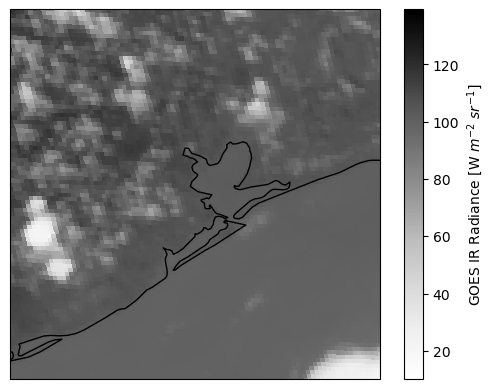

In [175]:
Rad = goes_ds.Rad.values[lat_max_bound:lat_min_bound,
                         lon_max_bound:lon_min_bound]
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
c= ax.pcolormesh(lon[lat_max_bound:lat_min_bound,
                  lon_max_bound:lon_min_bound],
              lat[lat_max_bound:lat_min_bound,
                  lon_max_bound:lon_min_bound], Rad, cmap='Greys')
plt.colorbar(c, label='GOES IR Radiance [W $m^{-2}\ sr^{-1}]$')
ax.coastlines()
ax.set_xlim([-96, -94])
ax.set_ylim([28.5, 30.5])

# CSAPR data access

The a1-level CSAPR data are available for public use on [ARM Data Disovery](https://adc.arm.gov/discovery/). In addition, we can use the Atmospheric Community Toolkit to download the July 12 and 13 CSAPR data. The DOI for the CSAPR2 a1-level data is 10.5439/1467901, which if accessed will bring you to the download page on ARM Data Discovery.

The first block of code below will look at the automated catalogue of CSAPR data created by Adam Theisen. This provides us with a view of what scanning mode the CSAPR was in for a given time period as well as the scanning geometry and precipitation coverage.

In [17]:
cell_track_info = pd.read_csv('/Users/rjackson/cell-track-stats/data/houcsapr.20220617.csv', index_col=["time"], parse_dates=True)
cell_track_info

,Unnamed: 0,scan_mode,scan_name,template_name,azimuth_min,azimuth_max,elevation_min,elevation_max,range_min,range_max,cell_azimuth,cell_range,cell_zh,ngates_gt_0,ngates_gt_10,ngates_gt_30,ngates_gt_50,ngates_gt_10_5km,ngates_gt40_5km,ngates
time,,,,,,,,,,,,,,,,,,,,
2022-06-17 00:00:03,0,rhi,rhi,hou-rhi-cell-track-05-deg,303.74450,303.74450,0.637207,4.383545,0.0,109900.0,NaN,NaN,NaN,0,0,0,0,0,0,0
2022-06-17 00:06:09,1,ppi,ppi,hou-ppi-cell-track-05-deg,297.59216,307.63367,3.021240,3.988037,0.0,109900.0,297.910767,700.0,30.930866,59,30,3,0,0,0,78
2022-06-17 00:06:40,2,rhi,rhi,hou-rhi-cell-track-05-deg,302.64587,302.64587,0.637207,4.383545,0.0,109900.0,302.645874,1800.0,-0.776333,0,0,0,0,0,0,2
2022-06-17 00:06:59,3,rhi,rhi,hou-rhi-cell-track-05-deg,302.55798,302.59094,0.637207,4.383545,0.0,109900.0,NaN,NaN,NaN,0,0,0,0,0,0,0
2022-06-17 00:07:18,4,rhi,rhi,hou-rhi-cell-track-05-deg,302.97546,302.99744,0.637207,4.383545,0.0,109900.0,302.975464,900.0,-2.972101,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-17 23:39:46,2826,rhi,rhi,hou-rhi-cell-track-10-deg,301.48132,301.50330,0.648193,9.382324,0.0,109900.0,301.503296,62400.0,40.327583,990,989,210,0,134,0,995
2022-06-17 23:40:02,2827,rhi,rhi,hou-rhi-cell-track-10-deg,305.70007,305.70007,0.648193,9.404297,0.0,109900.0,305.700073,13600.0,29.037998,12,6,0,0,0,0,20
2022-06-17 23:40:16,2828,rhi,rhi,hou-rhi-cell-track-10-deg,297.23510,297.26807,0.648193,9.382324,0.0,109900.0,297.235107,700.0,28.459156,28,25,0,0,0,0,34


For this notebook we are interested in the time periods where the CSAPR was scanning in PPI mode. For this entire time period, the CSAPR was in cell-tracking mode, meaning that it was focused on a single convective cell in the Houston region. This scanning strategy will have a much more frequent scans over a smaller area covered by a single convective cell and is designed to track the lifecycle of a convective cell.

In [18]:
start_hour = 20
end_hour = 22
print("All PPI scan times between %d UTC and %d UTC:" % (start_hour, end_hour))
for index in cell_track_info.index:
    if index.hour >= 20 and index.hour <= 22:
        if cell_track_info.loc[index].scan_mode == "ppi":
            print(index)

All PPI scan times between 20 UTC and 22 UTC:
2022-06-17 20:00:07
2022-06-17 20:00:51
2022-06-17 20:01:34
2022-06-17 20:02:17
2022-06-17 20:03:05
2022-06-17 20:03:48
2022-06-17 20:04:31
2022-06-17 20:05:22
2022-06-17 20:06:08
2022-06-17 20:06:59
2022-06-17 20:07:43
2022-06-17 20:08:29
2022-06-17 20:09:15
2022-06-17 20:09:56
2022-06-17 20:10:53
2022-06-17 20:11:39
2022-06-17 20:14:24
2022-06-17 20:16:25
2022-06-17 20:18:27
2022-06-17 20:20:25
2022-06-17 20:22:31
2022-06-17 20:24:30
2022-06-17 20:26:31
2022-06-17 20:28:30
2022-06-17 20:30:31
2022-06-17 20:32:29
2022-06-17 20:34:30
2022-06-17 20:36:30
2022-06-17 20:38:31
2022-06-17 20:40:32
2022-06-17 20:42:33
2022-06-17 20:44:31
2022-06-17 20:46:31
2022-06-17 20:48:25
2022-06-17 20:50:27
2022-06-17 20:52:21
2022-06-17 20:54:20
2022-06-17 20:56:22
2022-06-17 20:57:51
2022-06-17 20:59:19
2022-06-17 21:00:45
2022-06-17 21:02:10
2022-06-17 21:03:35
2022-06-17 21:04:59
2022-06-17 21:06:25
2022-06-17 21:07:51
2022-06-17 21:09:20
2022-06-17 21:

In [78]:
csapr = pyart.io.read('/Users/rjackson/TRACER-PAWS-NEXRAD-LMA/data/houcsapr2cfrS2.a1.20220712.200714.nc')

## Load LMA Flash data

Here we load the data from the Houston Lightning Mapping Array. The data are in standard netCDF format that is easily read by xarray.
The data are currently available for order at https://data.eol.ucar.edu/cgi-bin/codiac/fgr_form/id=100.016. Both the flash density data and locations of each flash are stored in the file.

In [79]:
lma_ds = xr.open_dataset('/Users/rjackson/TRACER-PAWS-NEXRAD-LMA/data/LYLOUT_220712_000000_86400_map500m.nc')
lma_ds

<xarray.Dataset>
Dimensions:                              (grid_x: 1001, grid_y: 1001,
                                          grid_x_edge: 1002, grid_y_edge: 1002,
                                          grid_time_edge: 289, grid_time: 288,
                                          number_of_flashes: 32453,
                                          number_of_stations: 14,
                                          number_of_events: 1483387)
Coordinates: (12/16)
  * grid_x                               (grid_x) float64 -2.5e+05 ... 2.5e+05
  * grid_y                               (grid_y) float64 -2.5e+05 ... 2.5e+05
  * grid_x_edge                          (grid_x_edge) float64 -2.502e+05 ......
  * grid_y_edge                          (grid_y_edge) float64 -2.502e+05 ......
  * grid_time_edge                       (grid_time_edge) datetime64[ns] 2022...
  * grid_time                            (grid_time) datetime64[ns] 2022-07-1...
    ...                                   ...
    event_id                             (number_of_events) uint64 ...
    flash_time_start                     (number_of_flashes) datetime64[ns] ...
    flash_init_latitude                  (number_of_flashes) float32 ...
    flash_init_longitude                 (number_of_flashes) float32 ...
    flash_init_altitude                  (number_of_flashes) float32 ...
    flash_id                             (number_of_flashes) uint64 ...
Dimensions without coordinates: number_of_stations, number_of_events
Data variables: (12/46)
    flash_extent_density                 (grid_time, grid_y, grid_x) float64 ...
    average_flash_area                   (grid_time, grid_y, grid_x) float64 ...
    stdev_flash_area                     (grid_time, grid_y, grid_x) float64 ...
    minimum_flash_area                   (grid_time, grid_y, grid_x) float64 ...
    average_flash_energy                 (grid_time, grid_y, grid_x) float64 ...
    event_count                          (grid_time, grid_y, grid_x) float64 ...
    ...                                   ...
    flash_init_x                         (number_of_flashes) float64 ...
    flash_init_y                         (number_of_flashes) float64 ...
    flash_ctr_x                          (number_of_flashes) float64 ...
    flash_ctr_y                          (number_of_flashes) float64 ...
    lon                                  (grid_y, grid_x) float64 ...
    lat                                  (grid_y, grid_x) float64 ...
Attributes:
    history:                  LMA source file created  Mon Sep 12 12:23:28 20...
    source:                   VHF Lightning Mapping Array
    comment:                  
    production_date:          2022-10-06 05:50:23 +00:00
    event_algorithm_name:      /home/lma_admin/lma_analysis -d 20220712 -t 00...
    flash_algorithm_name:     pyxlma DBSCAN
    institution:              unknown
    event_algorithm_version:   10.14.5R
    references:               
    production_site:          Default
    title:                    Lightning Mapping Array Dataset, L1b events and...
    flash_algorithm_version:  0.1

### Plot all of the data together -- July 13

Here, we will plot all of the data together using a combination of the PyART RadarMapDisplay and Cartopy GeoplotAxes functions. One thing to note for this case is that the CSAPR2 is not sampling the cell with the most intense lightning, but rather the weaker cell to the north with little lightning and warmer cloud tops. Showing all of the data together like this provides further context to the CSAPR2 observations.

On this day, the cell to the west of Galveston Bay had entrained a wildfire into its updraft as it developed. Therefore, this particular case makes for an excellent "polluted" aerosol case for comparison against cleaner convection. On this day, we observed the typical summertime seabreeze pattern over the Houston region that leads to the development of isolated convection during the early afternoon hours (like 20 UTC). However, as we can see, the CSAPR did not sample the cell of interest, but rather a weaker cell to its north that did not entrain wildfire smoke.

<>:14: DeprecationWarning: invalid escape sequence '\ '
<>:14: DeprecationWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_41252/293262808.py:14: DeprecationWarning: invalid escape sequence '\ '
  plt.colorbar(c, label='GOES IR Radiance [W $m^{-2}\ sr^{-1}]$')
/Users/rjackson/opt/anaconda3/envs/pyart_env2/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/rjackson/opt/anaconda3/envs/pyart_env2/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(28.5, 30.25)

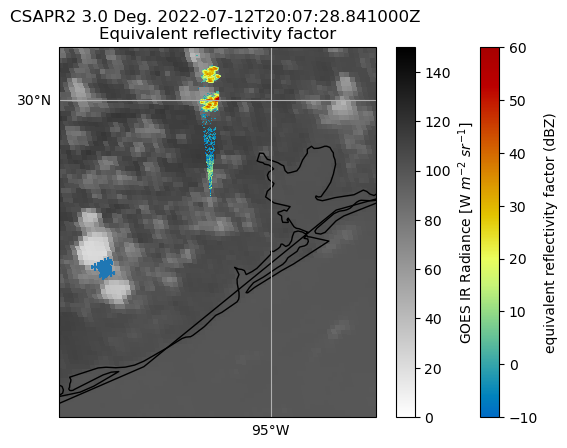

In [82]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
Rad = goes_ds.Rad.values[lat_max_bound:lat_min_bound,
                         lon_max_bound:lon_min_bound]
gatefilter = pyart.filters.GateFilter(csapr)
gatefilter.exclude_below('normalized_coherent_power', 0.50)

disp = pyart.graph.RadarMapDisplay(csapr)
c = ax.pcolormesh(lon[lat_max_bound:lat_min_bound,
                  lon_max_bound:lon_min_bound],
                  lat[lat_max_bound:lat_min_bound,
                  lon_max_bound:lon_min_bound], Rad, cmap='binary', vmin=0, vmax=150)
disp.plot_ppi_map('reflectivity', gatefilter=gatefilter, ax=ax, sweep=2, vmin=-10, vmax=60)

plt.colorbar(c, label='GOES IR Radiance [W $m^{-2}\ sr^{-1}]$')

flash_times = np.squeeze(np.argwhere(np.logical_and(lma_ds.flash_time_start.values > np.datetime64('2022-07-12T20:07:00'),
                                         lma_ds.flash_time_start.values < np.datetime64('2022-07-12T20:08:00'))))

ax.scatter(lma_ds.flash_center_longitude[flash_times], lma_ds.flash_center_latitude[flash_times], marker='+')
ax.coastlines()
ax.set_xlim([-96, -94.5])
ax.set_ylim([28.5, 30.25])

## June 17th case

This is a case of a storm that was tracked by CSAPR for about 90 minutes during the afternoon of June 17th 2022. We will use the same code from above to plot the radar/LMA overlays over the GOES IR radiance data for this case. This first block of code combines the above code to load and subset all of the necessary data for the overlays.

In [83]:
goes_ds = xr.open_dataset('../data/OR_ABI-L1b-RadC-M6C13_G16_s20221682056178_e20221682058562_c20221682059029.nc')
csapr = pyart.io.read('/Users/rjackson/TRACER-PAWS-NEXRAD-LMA/data/houcsapr2cfrS2.a1.20220617.203229.nc')
lma_ds = xr.open_dataset('/Users/rjackson/TRACER-PAWS-NEXRAD-LMA/data/LYLOUT_220617_000000_86400_map500m.nc')
lma_ds
lat, lon = calculate_degrees(goes_ds)
lat = np.nan_to_num(lat, -9999)
lon = np.nan_to_num(lon, -9999)
lat_range = (25., 35.)
lon_range = (-100., -95.)
lat_min = lat.min(axis=1)
lat_max = lat.max(axis=1)
lat_min_bound = np.argmin(np.abs(lat_min - lat_range[0]))
lat_max_bound = np.argmin(np.abs(lat_max - lat_range[1]))
lon_min = lon.min(axis=0)
lon_max = lon.max(axis=0)
lon_min_bound = np.argmin(np.abs(lon_min - lon_range[0]))
lon_max_bound = np.argmin(np.abs(lon_max - lon_range[1]))

Now we repeat again, but for the June 17th case.

<>:14: DeprecationWarning: invalid escape sequence '\ '
<>:14: DeprecationWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_41252/2371313213.py:14: DeprecationWarning: invalid escape sequence '\ '
  plt.colorbar(c, label='GOES IR Radiance [W $m^{-2}\ sr^{-1}]$')
/Users/rjackson/opt/anaconda3/envs/pyart_env2/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/rjackson/opt/anaconda3/envs/pyart_env2/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(28.5, 30.25)

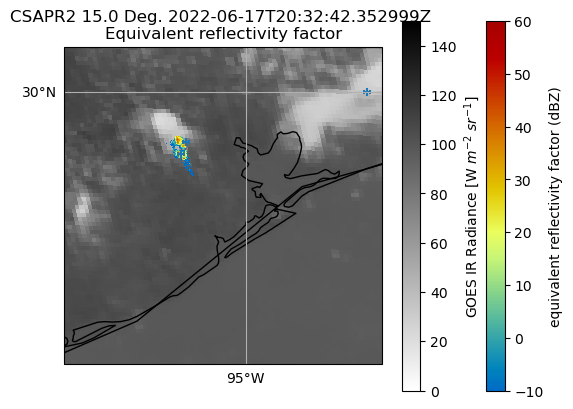

In [110]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
Rad = goes_ds.Rad.values[lat_max_bound:lat_min_bound,
                         lon_max_bound:lon_min_bound]
gatefilter = pyart.filters.GateFilter(csapr)
gatefilter.exclude_below('normalized_coherent_power', 0.50)

disp = pyart.graph.RadarMapDisplay(csapr)
c = ax.pcolormesh(lon[lat_max_bound:lat_min_bound,
                  lon_max_bound:lon_min_bound],
                  lat[lat_max_bound:lat_min_bound,
                  lon_max_bound:lon_min_bound], Rad, cmap='binary', vmin=0, vmax=150)
disp.plot_ppi_map('reflectivity', gatefilter=gatefilter, ax=ax, sweep=1, vmin=-10, vmax=60)

plt.colorbar(c, label='GOES IR Radiance [W $m^{-2}\ sr^{-1}]$')

flash_times = np.squeeze(np.argwhere(np.logical_and(lma_ds.flash_time_start.values > np.datetime64('2022-06-17T20:31:00'),
                                         lma_ds.flash_time_start.values < np.datetime64('2022-06-17T20:33:00'))))

ax.scatter(lma_ds.flash_center_longitude[flash_times], lma_ds.flash_center_latitude[flash_times], marker='+')
ax.coastlines()
ax.set_xlim([-96, -94.25])
ax.set_ylim([28.5, 30.25])

# Plotting RHI scans

We are also interested in the Range-Height Indicator scans provided by CSAPR2 as this cell evolves. The RHI scans will provide a vertical-cross section of the microphysical properties of the storm as it evolves. First, we will look for all of the time periods where we had RHI scans for this time period and choose one of interest for this notebook.

In [112]:
start_hour = 20
end_hour = 21
print("All RHI scan times between %d UTC and %d UTC:" % (start_hour, end_hour))
for index in cell_track_info.index:
    if index.hour >= start_hour and index.hour < end_hour:
        if cell_track_info.loc[index].scan_mode == "rhi":
            print(index)

All RHI scan times between 20 UTC and 21 UTC:
2022-06-17 20:00:36
2022-06-17 20:01:17
2022-06-17 20:02:03
2022-06-17 20:02:45
2022-06-17 20:03:33
2022-06-17 20:04:17
2022-06-17 20:04:59
2022-06-17 20:05:51
2022-06-17 20:06:37
2022-06-17 20:07:28
2022-06-17 20:08:12
2022-06-17 20:08:58
2022-06-17 20:09:44
2022-06-17 20:10:25
2022-06-17 20:11:22
2022-06-17 20:12:08
2022-06-17 20:15:05
2022-06-17 20:15:28
2022-06-17 20:15:48
2022-06-17 20:16:07
2022-06-17 20:17:07
2022-06-17 20:17:29
2022-06-17 20:17:49
2022-06-17 20:18:08
2022-06-17 20:19:08
2022-06-17 20:19:28
2022-06-17 20:19:47
2022-06-17 20:20:07
2022-06-17 20:21:07
2022-06-17 20:21:30
2022-06-17 20:21:52
2022-06-17 20:22:13
2022-06-17 20:23:12
2022-06-17 20:23:33
2022-06-17 20:23:53
2022-06-17 20:24:11
2022-06-17 20:25:11
2022-06-17 20:25:34
2022-06-17 20:25:55
2022-06-17 20:26:12
2022-06-17 20:27:11
2022-06-17 20:27:33
2022-06-17 20:27:55
2022-06-17 20:28:13
2022-06-17 20:29:11
2022-06-17 20:29:32
2022-06-17 20:29:53
2022-06-17 20:

Finally, this block of code will plot the altitudes and locations of each lightning strike overlaid over the RHI scan. SciPy's KDTree is used to find the nearest neighbors between the LMA lightning strike locations and the latitude and longitude locations of each gate in the RHI. After the nearest neighbors are found this provides us the altitude and range where the approximate location of the lightning strike would be. 

(51,)


(0.0, 15.0)

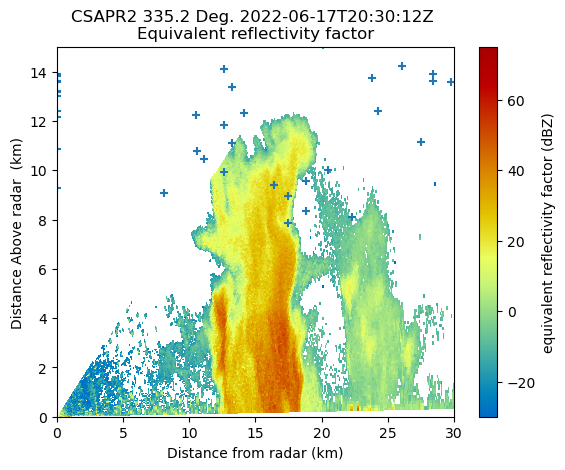

In [123]:
csapr_rhi = pyart.io.read('/Users/rjackson/TRACER-PAWS-NEXRAD-LMA/data/houcsapr2cfrS2.a1.20220617.203012.nc')
gatefilter = pyart.filters.GateFilter(csapr_rhi)
gatefilter.exclude_below('normalized_coherent_power', 0.50)

flash_times = np.squeeze(np.argwhere(np.logical_and(lma_ds.flash_time_start.values > np.datetime64('2022-06-17T20:30:00'),
                                         lma_ds.flash_time_start.values < np.datetime64('2022-06-17T20:31:00'))))
flash_alts = lma_ds.flash_init_altitude[flash_times]
flash_lons = lma_ds.flash_init_longitude[flash_times]
flash_lats = lma_ds.flash_init_latitude[flash_times]
rhi_lons = csapr_rhi.gate_longitude["data"].flatten()
rhi_lats = csapr_rhi.gate_latitude["data"].flatten()
rhi_alts = csapr_rhi.gate_altitude["data"].flatten()

kdtree_data = np.stack([rhi_lons, rhi_lats], axis=1)
kdtree = KDTree(kdtree_data)
inp_data = np.stack([flash_lons, flash_lats], axis=1)
dist, where_in_rhi = kdtree.query(inp_data)

flash_ranges = csapr_rhi.range["data"][where_in_rhi % csapr_rhi.ngates]
disp = pyart.graph.RadarMapDisplay(csapr_rhi)
disp.plot_rhi('reflectivity', gatefilter=gatefilter)
print(flash_alts.shape)
plt.scatter(flash_ranges/1e3, flash_alts/1e3, marker="+")
plt.xlim([0, 30])
plt.ylim([0, 15])